# Experiment with Regularization Techniques on MNIST
Using Keras. Minimal code for quick learning.

In [1]:
# Import libraries
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, 28*28).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28*28).astype('float32') / 255.0

# One-hot encode labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Split validation set
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## 1. Model without Regularization
Simple MLP with 2 hidden layers.

In [2]:
# Model without regularization
model_no_reg = models.Sequential([
    layers.Dense(512, activation='relu', input_shape=(784,)),
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model_no_reg.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

history_no_reg = model_no_reg.fit(x_train, y_train,
                                  epochs=20,
                                  batch_size=128,
                                  validation_data=(x_val, y_val),
                                  verbose=0)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 2. Model with L2 Regularization
Add `kernel_regularizer=regularizers.l2(0.001)` to dense layers.

In [3]:
# Model with L2 regularization
model_l2 = models.Sequential([
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(784,)),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(10, activation='softmax')
])

model_l2.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

history_l2 = model_l2.fit(x_train, y_train,
                          epochs=20,
                          batch_size=128,
                          validation_data=(x_val, y_val),
                          verbose=0)

## 3. Model with Dropout
Add `Dropout(0.5)` after each hidden layer.

In [4]:
# Model with Dropout
model_dropout = models.Sequential([
    layers.Dense(512, activation='relu', input_shape=(784,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

model_dropout.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

history_dropout = model_dropout.fit(x_train, y_train,
                                    epochs=20,
                                    batch_size=128,
                                    validation_data=(x_val, y_val),
                                    verbose=0)

## 4. Visualize Training vs Validation Loss & Accuracy

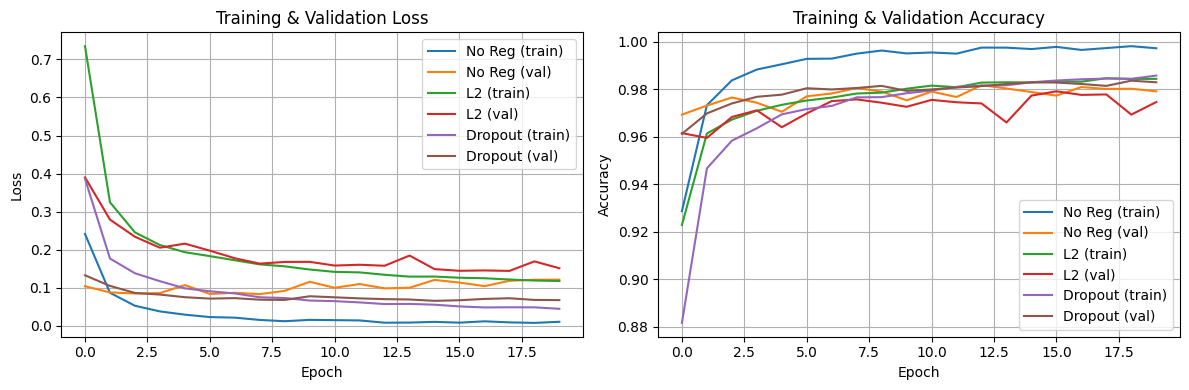

In [5]:
# Plot loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_no_reg.history['loss'], label='No Reg (train)')
plt.plot(history_no_reg.history['val_loss'], label='No Reg (val)')
plt.plot(history_l2.history['loss'], label='L2 (train)')
plt.plot(history_l2.history['val_loss'], label='L2 (val)')
plt.plot(history_dropout.history['loss'], label='Dropout (train)')
plt.plot(history_dropout.history['val_loss'], label='Dropout (val)')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_no_reg.history['accuracy'], label='No Reg (train)')
plt.plot(history_no_reg.history['val_accuracy'], label='No Reg (val)')
plt.plot(history_l2.history['accuracy'], label='L2 (train)')
plt.plot(history_l2.history['val_accuracy'], label='L2 (val)')
plt.plot(history_dropout.history['accuracy'], label='Dropout (train)')
plt.plot(history_dropout.history['val_accuracy'], label='Dropout (val)')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 5. Test Accuracy Comparison

In [6]:
# Evaluate on test set
test_loss_no, test_acc_no = model_no_reg.evaluate(x_test, y_test, verbose=0)
test_loss_l2, test_acc_l2 = model_l2.evaluate(x_test, y_test, verbose=0)
test_loss_drop, test_acc_drop = model_dropout.evaluate(x_test, y_test, verbose=0)

print(f"No Regularization  - Test Acc: {test_acc_no:.4f}")
print(f"L2 Regularization  - Test Acc: {test_acc_l2:.4f}")
print(f"Dropout            - Test Acc: {test_acc_drop:.4f}")

No Regularization  - Test Acc: 0.9805
L2 Regularization  - Test Acc: 0.9742
Dropout            - Test Acc: 0.9842
